# Rank-1 Introduction

# Import packages

In [ ]:
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import math
import random
from tqdm import trange, tqdm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
clear_output()
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [ ]:
p = 1
q = 2
w = 100

# Generate the Dataset

### Set parameters

In [ ]:
n1 = 10
n2 = 20
N = n1*n2
states = np.arange(n1, dtype=float)
nuisances = np.arange(n2, dtype=float)

### Generate X

In [ ]:
X = np.empty((N,2))
for i in range(N):
    #s = np.random.choice(states)
    #l = np.random.choice(nuisances)
    s = i//n2
    l = i%n2
    s = states[s]
    l = nuisances[l]
    X[i,0] = s    
    X[i,1] = l

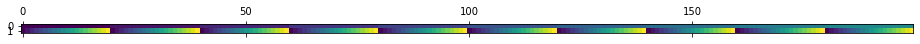

In [ ]:
plt.matshow(X.T)

# Set SymAE

### Set CENc, NEnc, Dec

In [ ]:
class CEnc(tf.keras.Model):
    def __init__(self, p, w):
        super(CEnc, self).__init__(name='sym_encoder')
    def call(self, x):
        return x[:,0:1]
    
# 你是在让 nuisance encoder 记住states
class NEnc(tf.keras.Model):
    def __init__(self, q, w):
        super(NEnc, self).__init__(name='nui_encoder')
        self.d1=tfkl.Dense(1, use_bias=False,
                           kernel_initializer='zeros')
        self.r1 = tf.keras.layers.RepeatVector(q)
        self.f1 = tf.keras.layers.Flatten()
    def call(self, x):
        x=self.d1(x)
        #x=tf.reduce_sum(x, axis=-1, keepdims=True)
        x=self.r1(x)
        x=self.f1(x)
        return x
    
class Dec(tf.keras.Model):
    def __init__(self, w):
        super(Dec, self).__init__(name='dec')
        self.d1=tfkl.Dense(w, activation=tf.keras.layers.LeakyReLU(), use_bias=False)#tf.keras.layers.LeakyReLU())
        self.d2=tfkl.Dense(1, use_bias=False)
    def call(self, x):
        x=self.d1(x)
        #x=self.d2(x)
        x=tf.reduce_sum(x, axis=-1, keepdims=True)/10
        return x

### Dropout

In [ ]:
class LatentCat(tf.keras.Model):
    def __init__(self):
        super(LatentCat, self).__init__(name='latentcat')
    def call(self, zsym, znui, mask=1):
        znui = znui*mask
        z = tfkl.concatenate([zsym, znui])
        return z

### model

In [ ]:
class SymAE(tf.keras.Model):
    def __init__(self, p, q, w): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder = CEnc(p, w)
        self.sym_encoder=sym_encoder
        
        # Build nuisance encoder
        nui_encoder = NEnc(q, w)
        self.nui_encoder = nui_encoder
        
        #Build latentcat
        latentcat = LatentCat()
        self.latentcat = latentcat  
        
        #Build dec in decoder
        dec = Dec(w)
        self.dec = dec
        
        # Build encoder
        encoder_input = tfk.Input(shape=(2), dtype='float32', name='encoder_input')
        znui = nui_encoder(encoder_input); zsym = sym_encoder(encoder_input)
        encoder_output = latentcat(zsym, znui)
        encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder=encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(1+q), name='latentcode')
        decoder_output = dec(decoder_input)
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder=decoder
        
    def call(self, x, mask=1):
        zsym = self.sym_encoder(x)
        znui = self.nui_encoder(x)
        z = self.latentcat(zsym, znui, mask)
        x_hat = self.dec(z)
        return x_hat
    
    def redatum(self, X1, X2):
        return model.decoder(
            model.latentcat(
                model.sym_encoder(X1), 
                model.nui_encoder(X2)))

In [ ]:
#model(X)

### Initialize SymAE

In [ ]:
model = SymAE(p,q,w)
# Please directly modify My_Dropout to change dropout rate
path = './p=%d,q=%d,w=%d'%(p,q,w)
clear_output()

In [ ]:
try:
    #model.load_weights(path+'/checkpoint')
    print("weight exists")
except:
    print("weight doesn't exist")

weight exists



### Select optimizer

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
clear_output()

# Train

In [ ]:
mask_list=[]
for a in range(2**10):
    if a==0:
        continue
    cur = []
    for i in range(10):
        cur.append(a%2)
        a=a//2
    mask_list.append(cur)

In [ ]:
mask_list=[(1,1),(1,0),(0,1)]

### Define loss

In [ ]:
X1 = np.empty((N,2))
X2 = np.empty((N,2))
for i in range(N):
    X1[i,0] = np.random.choice(states)    
    X1[i,1] = np.random.choice(nuisances)
    X2[i,0] = np.random.choice(states)    
    X2[i,1] = np.random.choice(nuisances)
def redatum_loss():
    redata = model.redatum(X1,X2)
    origin = np.empty((N,2))
    origin[:,0] = X1[:,0]
    origin[:,1] = X2[:,1]
    return mse(redata, origin[:,1:2])

def loss_rec(model, x):
    y = x[:,1:2]
    s=0
    for mask in mask_list:
        x_hat_1 = model(x, mask=mask)
        s += mse(y, x_hat_1)
    return s

@tf.function
def train_step(model, X):
    with tf.GradientTape() as tape:
        loss = loss_rec(model, X)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

### Plot NEnc: R^2->R^2, Dec: R^3->R^2

In [ ]:
def plot_nenc():
    Z = model.nui_encoder(X).numpy().reshape(n1,n2,2)
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5), dpi=144)
    levels = np.linspace(np.min(Z), np.max(Z), 10)
    cont0 = axs[0].contourf(states, nuisances, Z[:,:,0].T, levels=levels)
    axs[0].set_xlabel('state')
    axs[0].set_ylabel('nuisance')
    axs[0].set_title('1st latent nuisance')
    im = axs[1].contourf(states, nuisances, Z[:,:,1].T, levels=levels)
    axs[1].set_xlabel('state')
    axs[1].set_ylabel('nuisance')
    axs[1].set_title('2nd latent nuisance')
    fig.colorbar(im, ax=axs.ravel().tolist())
    return fig

### Train

In [ ]:
# model.nui_encoder.d1.trainable = True
# W = np.array([[0.1],[0.1]])
# model.nui_encoder.d1.set_weights([W])

In [ ]:
# model.nui_encoder.d1.get_weights()

In [ ]:
losses=[]
redata=[]
theta=[]
conserve=[]
model.nui_encoder.d1.trainable = True
writer = imageio.get_writer(path+'/NEnc.gif', fps=20)
for epoch in range(10000):
    loss_rec = train_step(model, X)
    losses.append(loss_rec)
    redata.append(redatum_loss())
    
    T = np.empty((w,3))
    T[:,0:3] = model.dec.d1.weights[0].numpy().T
    df = pd.DataFrame(T, columns=['b','c','d'])
    W = model.nui_encoder.weights[0].numpy().T
    theta.append([model.nui_encoder.weights[0].numpy(),
                  model.dec.d1.weights[0].numpy()])
    conserve.append( np.sum(T[:,1:3]**2) - np.sum(W**2) )
    print(epoch, loss_rec,'\n', W)
    print(mse(X[:,1:2], model(X, mask=[1,1])))
    print(mse(X[:,1:2], model(X, mask=[1,0])))
    print(mse(X[:,1:2], model(X, mask=[0,1])))
    if epoch%100==-1:
        # fig = plot_nenc()
        # fig.suptitle('Epoch {:d}, loss {:f}, redatum {:f}'
        #              .format(epoch,loss_rec,redata[epoch]))
        # canvas = FigureCanvasAgg(fig)
        # canvas.draw()
        # buf = canvas.buffer_rgba()
        # im = np.asarray(buf)
        # writer.append_data(im)
        # plt.show()
        t1 = go.Scatter(x=df['c'], y=df['d'], mode='markers')
        # t2 = go.Scatter3d(x=df['a'], y=df['w1'], z=df['w2'], mode='markers')
        # t3 = go.Scatter3d(x=df['a'], y=df['w1'], z=df['w3'], mode='markers')
        fig = go.Figure(data=[t1])
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
    clear_output(wait=True)
writer.close()  

9999 tf.Tensor(22.157063, shape=(), dtype=float32)


### Save weights

In [ ]:
#model.save_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
model.save_weights(path+'/checkpoint')
print("weights saved")

weights saved


### Loss-epoch graph

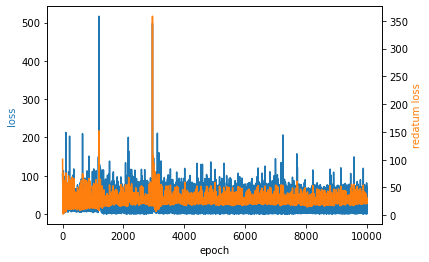

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(len(losses)),losses,'C0')
ax2.plot(range(len(redata)),redata,'C1')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='C0')
ax2.set_ylabel('redatum loss', color='C1')
plt.savefig(path+'/train.pdf', format='pdf', bbox_inches='tight')
plt.show()

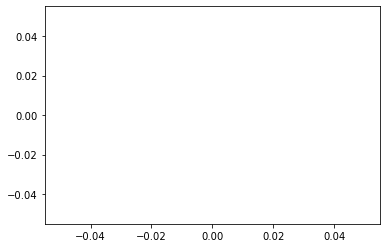

In [ ]:
L=len(theta)
L=3000
plt.plot(range(len(conserve)),conserve)

In [ ]:
for j in range(w):
    plt.plot(range(L),[theta[i][1][2,j] for i in range(L)])

IndexError: list index out of range

# Visualize training loss

### Plot D and SymAE(X)

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20,2))
axs[0].matshow(X.T)
axs[1].matshow(model(X).numpy().T)

# PCA

### q space (latent nuisance space)

In [ ]:
Ns = model.nui_encoder(X)
df = pd.DataFrame(Ns, columns = np.arange(q))
df_nui = pd.DataFrame(X[:,1], columns=['nuisance'])
df_sta = pd.DataFrame(X[:,0], columns=['state'])
df = pd.concat([df,df_nui,df_sta], axis=1)
from plotly.subplots import make_subplots
fig = make_subplots(rows=q, cols=1, 
                    shared_xaxes=True,
                    vertical_spacing=0.01)
for i in trange(q):
    fig.add_trace(
        go.Scatter(x=df['nuisance'], 
                   y=df[i], 
                   marker=dict(color=df['state']),
                   mode='markers'
                  ), 
        row=i+1, col=1
        )
#fig = px.scatter(df, x='nuisance', y=4, color='state')
fig.update_layout(title_text="q-space PCA, x:real nuisance, \
y:latent code, color:state")
#fig.update_traces(textposition='top center')
fig.update_layout(height=q*200, width=600)
fig.update_layout(showlegend=False)
fig.write_image(path+'/latent_q.pdf')
fig.show()

### 5-dim gas

In [ ]:
T = np.empty((w,3))
T[:,0:3] = model.dec.d1.weights[0].numpy().T
df = pd.DataFrame(T, columns=['b','c','d'])
W = model.nui_encoder.weights[0].numpy().T

In [ ]:
df = df.sort_values(by=['b'])
df = df.reset_index(drop=True)

In [ ]:
px.scatter(df)
# t1 = go.Scatter3d(x=df['a'], y=df['w1'], z=df['w2+w3'], mode='markers')
# t2 = go.Scatter3d(x=df['a'], y=df['w1'], z=df['w2'], mode='markers')
# t3 = go.Scatter3d(x=df['a'], y=df['w1'], z=df['w3'], mode='markers')
# fig = go.Figure(data=[t1,t2,t3])
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.update_traces(marker={'size': 2, 'opacity':0.8})
# fig

In [ ]:
W = model.nui_encoder.weights[0].numpy().T

In [ ]:
W